In [1]:
is_colab = True
if is_colab:
    data_dir = 'https://raw.githubusercontent.com/utm529f/sukkiri-ml-codes-polars/main/datafiles'
else:
    data_dir = '../datafiles'

In [2]:
import polars as pl
df = pl.read_csv(f'{data_dir}/Boston.csv') # csvの読み込み
df.head(2) # 先頭2行の表示

CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
str,f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64
"""high""",0.0,18.1,0,0.718,3.561,87.9,1.6132,24,666,20.2,354.7,7.12,27.5
"""low""",0.0,8.14,0,0.538,5.95,82.0,3.99,4,307,21.0,232.6,27.71,13.2


In [3]:
df.shape

(100, 14)

In [4]:
df2 = df.fill_null(strategy='mean') # 列ごとの平均値で欠損値の穴埋め

In [5]:
dummy = df2['CRIME'].to_dummies(drop_first = True)
df3 = pl.concat([df2, dummy], how='horizontal') # df2とdummyを列方向に結合
df3 = df3.drop(['CRIME']) # 元のCRIMEを削除

df3.head(2)

ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,CRIME_low,CRIME_very_low
f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,u8,u8
0.0,18.1,0,0.718,3.561,87.9,1.6132,24,666,20.2,354.7,7.12,27.5,0,0
0.0,8.14,0,0.538,5.95,82.0,3.99,4,307,21.0,232.6,27.71,13.2,1,0


In [6]:
from sklearn.preprocessing import StandardScaler
 # 中身が整数だと、fit_transformで警告になるので、
# float型に変換（省略可能）
df4 = df3.with_columns(pl.all().cast(float))
# 標準化
sc = StandardScaler()
sc_df = sc.fit_transform(df4)

In [7]:
from sklearn.decomposition import PCA

In [8]:
model = PCA(n_components=2, whiten=True) # モデル作成

In [9]:
# モデルに学習させる
model.fit(sc_df)

,n_components,2
,copy,True
,whiten,True
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [10]:
# 新規の第１軸（第１主成分とも呼ぶ）の固有ベクトル
print(model.components_[0])
print('-----')
# 新規の第2軸（第2主成分とも呼ぶ）の固有ベクトル
print(model.components_[1])

[-0.22583463  0.35924751  0.04222166  0.34994154 -0.19485437  0.29793772
 -0.29980845  0.30723083  0.32825514  0.16247982 -0.18254593  0.27543938
 -0.20184299  0.03821554 -0.31487326]
-----
[-0.15353621  0.02839336  0.1978467   0.13819056  0.40450846  0.20067176
 -0.29340852 -0.10329984 -0.11563235 -0.34043812  0.05664993 -0.17820353
  0.44365871  0.42282233 -0.27726953]


In [11]:
new = model.transform(sc_df)

new_df = pl.DataFrame(new)
new_df.head(3)

column_0,column_1
f64,f64
1.490569,-0.680898
0.703291,-0.251218
-1.403618,-0.613639


In [12]:
new_df.columns = ['PC1', 'PC2']
# 標準化済の既存データ（numpy)をデータフレーム化
df5 = pl.DataFrame(sc_df, schema=df4.columns)
# 2つのデータフレームを列方向に結合
df6 = pl.concat([df5, new_df], how='horizontal')

In [13]:
df_corr = df6.corr() # 相関係数の計算
df_index = pl.DataFrame({'column': df6.columns})
df_corr = pl.concat([df_index, df_corr], how='horizontal')
df_corr[:-2, ['column', 'PC1', 'PC2']]

column,PC1,PC2
str,f64,f64
"""ZN""",-0.560745,-0.226322
"""INDUS""",0.892008,0.041854
"""CHAS""",0.104836,0.291639
"""NOX""",0.868901,0.203702
"""RM""",-0.483821,0.596272
…,…,…
"""B""",-0.45326,0.083506
"""LSTAT""",0.683913,-0.262684
"""PRICE""",-0.501174,0.653982


In [14]:
# わかりやすいように変数に代入
pc_corr = df_corr[:-2, ['column', 'PC1', 'PC2']]

pl.Config.set_tbl_rows(40)
pc_corr.sort(by='PC1', descending=True)['column', 'PC1']

column,PC1
str,f64
"""INDUS""",0.892008
"""NOX""",0.868901
"""TAX""",0.815054
"""RAD""",0.762851
"""AGE""",0.739776
"""LSTAT""",0.683913
"""PTRATIO""",0.403436
"""CHAS""",0.104836
"""CRIME_low""",0.094889


In [15]:
pc_corr.sort(by='PC2', descending=True)['column', 'PC2']

column,PC2
str,f64
"""PRICE""",0.653982
"""CRIME_low""",0.623267
"""RM""",0.596272
"""AGE""",0.295803
"""CHAS""",0.291639
"""NOX""",0.203702
"""B""",0.083506
"""INDUS""",0.041854
"""RAD""",-0.152271


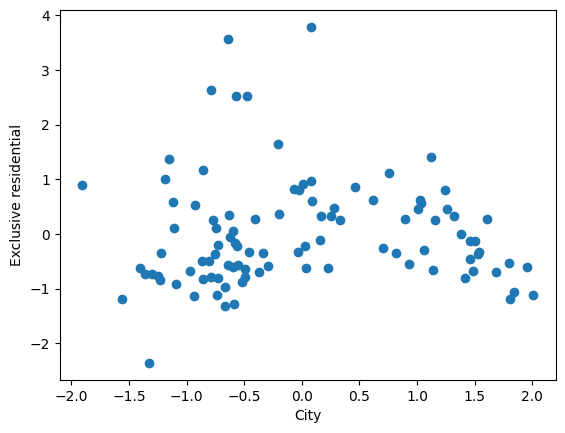

In [16]:
#都市の発展度合いと住環境の良さ
col = ['City', 'Exclusive residential']

new_df.columns = col # 列名の変更

import matplotlib.pyplot as plt
plt.scatter(
    new_df.select('City').to_series(), 
    new_df.select('Exclusive residential').to_series()
)
plt.xlabel('City')
plt.ylabel('Exclusive residential')
plt.show()

In [17]:
model = PCA(whiten = True)

# 学習と新規軸へのデータの当てはめを一括で行う
tmp = model.fit_transform(sc_df)
tmp.shape

(100, 15)

In [18]:
model.explained_variance_ratio_ # 寄与率

array([0.41101568, 0.14485778, 0.10200017, 0.06449032, 0.0623356 ,
       0.05808597, 0.04842057, 0.02884897, 0.02142209, 0.01831361,
       0.01573349, 0.01068594, 0.00918258, 0.00276074, 0.00184648])

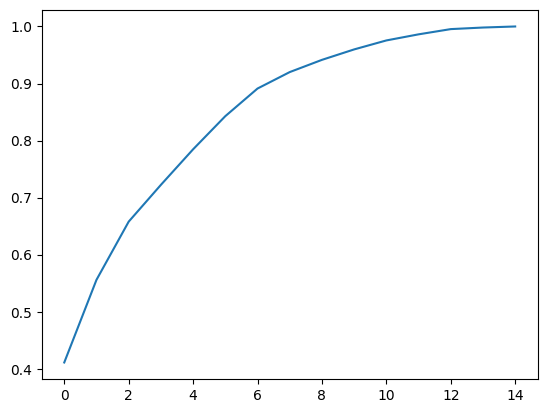

In [19]:
ratio = model.explained_variance_ratio_ # 寄与率のデータ集合

array = [] # 第N列までの累積寄与率を格納するリスト
for i in range(len(ratio)):
# 累積寄与率の計算
    ruiseki = sum(ratio[0:(i+1)])

    array.append(ruiseki) # 累積寄与率の格納

# 第N列の累積寄与率を折れ線グラフ化
plt.plot(array)
plt.show()

In [20]:
thred = 0.8 # 累積寄与率のしきい値
for i in range(len(array)):
 # 第(i + 1)列の累積寄与率がthredより大きいかチェック
    if array[i] >= thred:
        print(i + 1)
        break

6


In [21]:
model = PCA(n_components=6, whiten = True)

model.fit (sc_df) # 学習

# 元データを新規の列（6列）に当てはめる
new = model.transform(sc_df)

In [22]:
# 主成分分析の結果をデータフレームに変換
col = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
new_df2 = pl.DataFrame(new, schema = col)

# データフレームをcsvファイルとして保存
new_df2.write_csv('boston_pca.csv')

In [23]:
df = pl.read_csv(f'{data_dir}/cinema.csv')
df = df.drop('cinema_id')
# 欠損値補完
df = df.fill_null(strategy='mean')
# 可能なら外れ値の確認もするが
# 今回は割愛

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_df = sc.fit_transform(df)
sc_df = pl.DataFrame(sc_df, schema=df.columns)

In [25]:
# 累積寄与率を調べる
from sklearn.decomposition import PCA
model = PCA(whiten=True)
model.fit(sc_df)

total = []
for i in model.explained_variance_ratio_:
    if len(total) == 0:
        total.append(i)
    else:
        tmp = total[-1] + i
        total.append(tmp)
total

[np.float64(0.5401232593619151),
 np.float64(0.726177786311325),
 np.float64(0.8624897315401375),
 np.float64(0.9677586180693523),
 np.float64(1.0)]

In [26]:
model = PCA(whiten=True, n_components = 3)
model.fit(sc_df)
new = pl.DataFrame(model.transform(sc_df), schema=['pc1', 'pc2', 'pc3'])
new_df = pl.concat([new, sc_df], how='horizontal')
cor_df = new_df.corr()
df_index = pl.DataFrame({'column': new_df.columns})
cor_df = pl.concat([df_index, cor_df], how='horizontal')
cor_df[:3, ['column', 'SNS1', 'SNS2', 'actor', 'original', 'sales']]

column,SNS1,SNS2,actor,original,sales
str,f64,f64,f64,f64,f64
"""pc1""",0.736377,0.598543,0.837999,0.46913,0.936903
"""pc2""",-0.050659,-0.534137,-0.037107,0.800529,0.013397
"""pc3""",-0.5315,0.536666,-0.01729,0.324854,-0.072306
